In [82]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import astropy.stats as stats

from astropy.time import Time
from datetime import datetime, timedelta

from IPython.display import display
from ipywidgets import interact, widgets

Input parameters required:
* Full path to data file containing timestamps and velocity channels of interest
* Julian date format for timestamp conversion
* Observation epoch

Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

In [83]:
#input_file = widgets.Text(value='data/iktausMWch_blue_red_channels_detrended.tscat',
#input_file = widgets.Text(value='data/iktausMWch_blue_red_channels.tscat',
#input_file = widgets.Text(value='data/oh3573s2_blue_red_channels_detrended.ts',
#input_file = widgets.Text(value='data/oh3573s2_blue_red_channels.ts',
input_file = widgets.Text(value='data/vmic_blue_red_channels_detrended.tscatJD',
#input_file = widgets.Text(value='data/vmic_blue_red_channels.tscatJD',
                          placeholder='Type full path to HartRAO data file here',
                          description='filename:',
                          disabled=False,
                          layout={'width':'900px'},
                         )
input_epoch = widgets.Text(value='0',
#input_epoch = widgets.Text(value='2440000',
                           placeholder='epoch',
                           description='epoch:',
                           disabled=False,
                           layout={'width':'250px'},
                          )
input_tsfmt = widgets.Dropdown(value='mjd',
#input_tsfmt = widgets.Dropdown(value='jd',
                               options=['mjd', 'jd'],
                               description='JD format:',
                               disabled=False,
                               layout={'width':'200px'},
                              )
ui = widgets.VBox([input_file, input_epoch, input_tsfmt])
display(ui)

VkJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11J2RhdGEvdm1pY19ibHVlX3JlZF9jaGFubmVscy50c2NhdEpEJywgZGVzY3JpcHRpb249dSdmaWxlbmFtZTonLCBsYXlvdXQ9TGF5b3V0KHdpZHTigKY=


In [84]:
filename = input_file.value
tsformat = input_tsfmt.value
epoch = float(input_epoch.value)
print("Reading OH monitoring file {} using epoch {} and '{}' format for time interpretation".
      format(filename, epoch, tsformat.upper()))

Reading OH monitoring file data/vmic_blue_red_channels.tscatJD using epoch 0.0 and 'MJD' format for time interpretation


In [85]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [86]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD, -4.072, 7.085

Spectral data size (#ts, #ch) = (157, 2)


In [87]:
blue_spectrum = spectra[:, 0]
blue_velocity = chan_vel[0]
red_spectrum = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

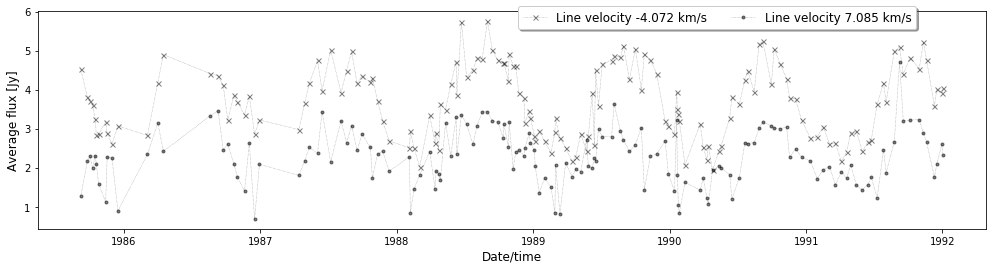

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='k', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(jd_datetime, red_spectrum,
        color='k', marker='.', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

### Compute the periodogram
Find the best period in days

In [89]:
def upsample(ts_start, ts_end, dt):
    upsample_time = [ts_start]
    while upsample_time[-1] < ts_end:
        next_time = upsample_time[-1] + dt
        upsample_time.append(next_time)
    return upsample_time

def lomb_scargle(timestamp, spectrum, dt=None):
    
    ls_hndl = stats.LombScargle(timestamp, spectrum,
                                fit_mean=True, center_data=True,
                                nterms=1,
                               )
    frequency, power = ls_hndl.autopower(method='slow',normalization='psd')
    period = 1./frequency[np.argmax(power)]  # period with most power / strongest signal
    
    # denoise and smooth
    if dt is not None:
        model_time = upsample(timestamp[0], timestamp[-1], dt)
        model_spectrum = ls_hndl.model(model_time, frequency[np.argmax(power)])
    else:
        model_time = timestamp
        model_spectrum = ls_hndl.model(timestamp, frequency[np.argmax(power)])
    return [power, frequency, period, model_time, model_spectrum]

In [90]:
# we will upsample the signal for CSD calculations
dt = np.diff(ts_jd).min()

[blue_power,
 blue_frequency,
 blue_period,
 blue_time,
 blue_model] = lomb_scargle(ts_jd.value,
                            blue_spectrum,
                            dt=dt.value)
#blue_time = Time(blue_time, format='mjd')
blue_time = Time(np.array(blue_time), format=tsformat)

[red_power,
 red_frequency,
 red_period,
 red_time,
 red_model] = lomb_scargle(ts_jd.value,
                           red_spectrum,
                            dt=dt.value)
#red_time = Time(red_time, format='mjd')
red_time = Time(np.array(red_time), format=tsformat)


In [91]:
print(header)
period = (blue_period+red_period)/2
err = np.abs(np.max([blue_period, red_period]) - period)
print('Observed period = {:.2f} pm {:.2f} [days]'.format(period, err))

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD, -4.072, 7.085

Observed period = 384.86 pm 6.41 [days]


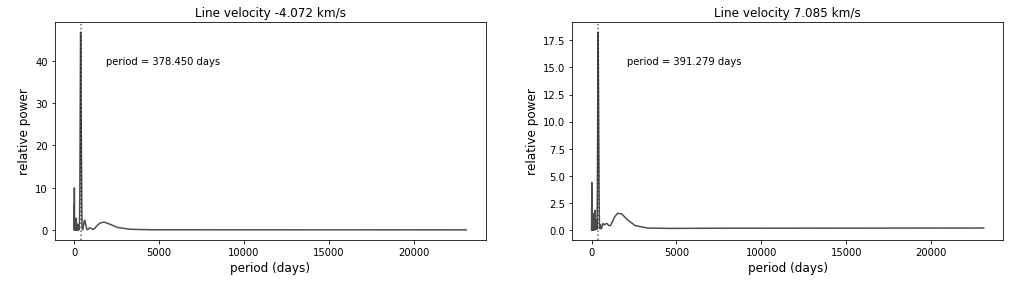

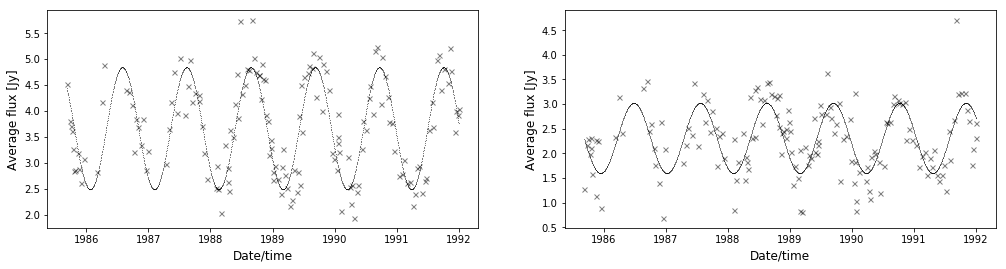

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
period_range = 1./blue_frequency  # period is the inverse of frequency
axs[0].plot(period_range, blue_power, 'k', alpha=0.7)
axs[0].axvline(blue_period, color='k',linestyle=':', alpha=0.6)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))
axs[0].set_xlabel('period (days)', fontsize=12)
axs[0].set_ylabel('relative power', fontsize=12)
axs[0].text(-0.05,0.83,
            'period = {:.3f} days'.format(blue_period),
            transform=ax.transAxes,
            color='k')

period_range = 1./red_frequency  # period is the inverse of frequency
axs[1].plot(period_range, red_power, 'k', alpha=0.7)
axs[1].axvline(red_period, color='k',linestyle=':', alpha=0.6)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))
axs[1].set_xlabel('period (days)', fontsize=12)
axs[1].set_ylabel('relative power', fontsize=12)
axs[1].text(0.5,0.83,
            'period = {:.3f} days'.format(red_period),
            transform=ax.transAxes,
            color='k')

fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
axs[0].plot(jd_datetime, blue_spectrum,
        color='k', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[0].plot(blue_time.datetime, blue_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)

axs[1].plot(jd_datetime, red_spectrum,
        color='k', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[1].plot(red_time.datetime, red_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)

plt.show()

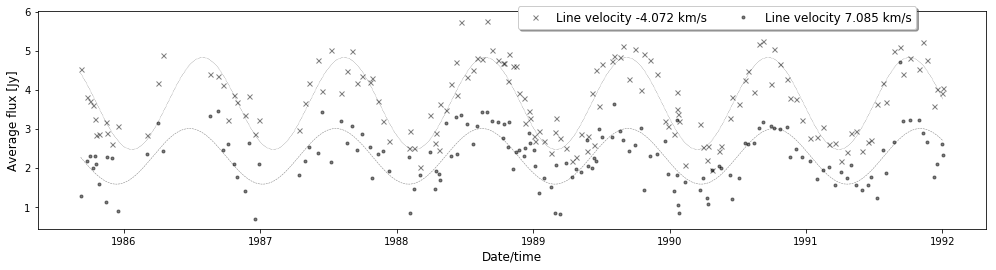

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='k', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='k', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_spectrum,
        color='k', marker='.', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='k', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

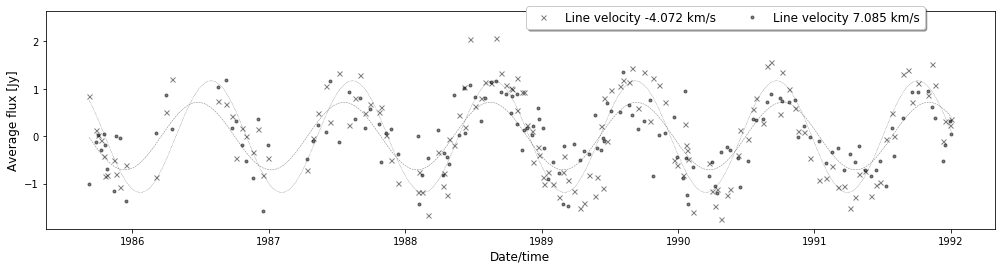

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum-blue_spectrum.mean(),
        color='k', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model-blue_model.mean(),
        color='k', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_spectrum-red_spectrum.mean(),
        color='k', marker='.', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model-red_model.mean(),
        color='k', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

Relation between time delay ($\Delta T$) and phase lag ($\phi$): $2\pi \Delta T = \phi$

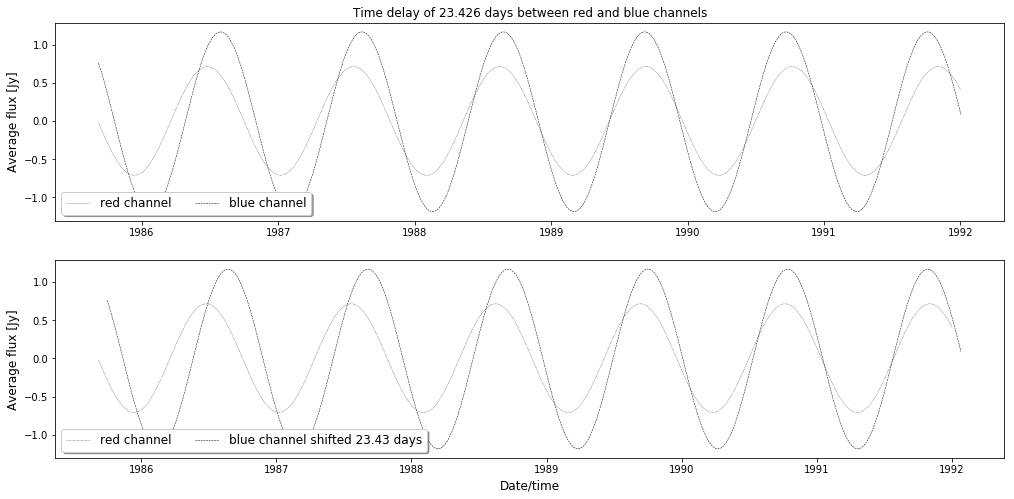

In [95]:
# relative phase shift between two signals from cross correlation
fs = 1./dt  # Sample frequency 1/d
freq = 1./period  # Frequency in 1/d

blue_channel = blue_model-blue_model.mean()
red_channel = red_model-red_model.mean()

phase_offset_rad=np.arccos(np.dot(blue_channel, red_channel)/(np.linalg.norm(blue_channel)*np.linalg.norm(red_channel)))
time_delay = phase_offset_rad/(2.*np.pi*freq)

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(17, 8),
                        facecolor='white')
axs[0].plot(red_time.datetime, red_model-red_model.mean(),
            color='k', linestyle=':', linewidth=0.5,
            label='red channel')
axs[0].plot(blue_time.datetime, blue_model-blue_model.mean(),
            color='k', linestyle='--', linewidth=0.5,
            label='blue channel')
axs[0].set_title('Time delay of {:.3f} days between red and blue channels'.format(time_delay))
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

axs[1].plot(red_time.datetime, red_model-red_model.mean(),
            color='k', linestyle=':', linewidth=0.5,
            label='red channel')
axs[1].plot(blue_time.datetime+timedelta(days=time_delay), blue_model-blue_model.mean(),
            color='k', linestyle='--', linewidth=0.5,
            label='blue channel shifted {:.2f} days'.format(time_delay))
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)
plt.show()

In [96]:
def get_folded_phase(ts, period):
    """Fold the observation times with the best period of the variable signal."""
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (ts / period) % 1
    return phase

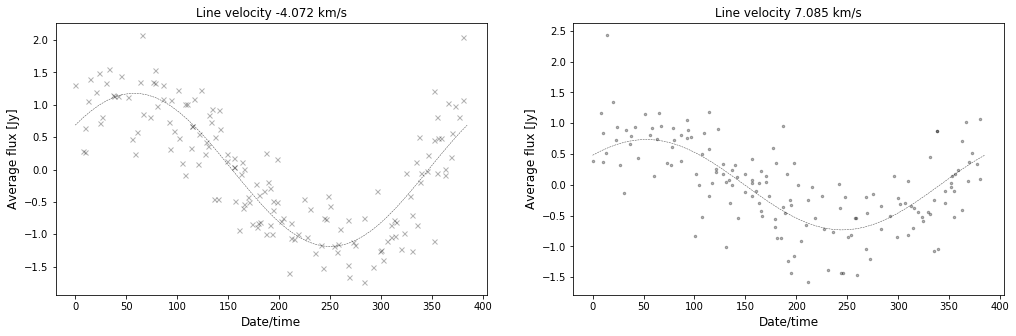

In [97]:
# compute model fitted values
phase_fit = np.linspace(0., 1.)
phase = get_folded_phase(ts_jd.value, period)

blue_mag_fit = stats.LombScargle(
                ts_jd.value, blue_spectrum - blue_spectrum.mean()).model(
                    t=phase_fit * period, frequency=1./period)

red_mag_fit = stats.LombScargle(
                ts_jd.value, red_spectrum - red_spectrum.mean()).model(
                    t=phase_fit * period, frequency=1./period)

# Plot folded lightcurve
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 5),
                        facecolor='white')
axs[0].plot(period*phase, blue_spectrum - blue_spectrum.mean(),
            color='k', marker='x', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[0].plot(period*phase_fit, blue_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))

axs[1].plot(period*phase, red_spectrum - red_spectrum.mean(),
            color='k', marker='.', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[1].plot(period*phase_fit, red_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))

plt.show()